In [1]:
import logging
import sys
import datetime
import pickle
from tqdm import tqdm
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity

## for correct lstm shape - https://www.kaggle.com/code/imegirin/multivariate-time-series-modeling-with-pytorch


In [2]:
from torch.utils.data import TensorDataset

In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt;
np.random.seed(42);
from sklearn.metrics import roc_auc_score;

In [4]:
from sklearn.metrics import roc_auc_score;
from sklearn.metrics import classification_report;

In [5]:
pd.set_option('display.max_columns', None);

In [6]:
df=pd.read_pickle('appmath.pkl')[['graph_id', 'user_id', 
       'goal_id',
        'interaction_end_time',
       'learning_objective_name', 'atom_id', 
       'correct', 'time_spent_answering_s', 'time_spent_on_instruction_s',
       'goal_progress',
       'target_status_and_progress', 'prev_concept_narrative',
       'duration_s', 'is_target']]  

In [7]:
df2=pd.read_csv('prereq_edges.csv')

In [8]:
G=nx.Graph()

for _,i in df2.iterrows():    
       
        G.add_edge(i['source_lo_title'],i['dest_lo_title'])
        
subgraphs=[G.subgraph(i) for i in nx.connected_components(G)]

for num,sub in enumerate(subgraphs):
    
    nx.set_node_attributes(sub,num,'subGraphId')

nodeSubGraphId={}
for g in subgraphs:
    for node in g.nodes(data=True):
         nodeSubGraphId[node[0]]= node[1]['subGraphId']
            
subgraphsNodeCountDict={ num: g.number_of_nodes() for num,g in  enumerate(subgraphs)}

In [9]:
for col in df.columns:
    if df[col].dtype.name=='category':
        df[col]=df[col].astype(str)

In [10]:
df['loGraphID']=df.learning_objective_name.apply(lambda x: nodeSubGraphId.get(x) )

In [11]:
difficulty=df[~df.correct.isna()].groupby('atom_id')['correct'].mean().reset_index().rename(columns={'correct':'difficulty'})
df=df.merge(difficulty,how='left',on='atom_id')

In [12]:
lo_difficulty=df[~df.correct.isna()].groupby('learning_objective_name')['correct'].mean().reset_index().rename(columns={'correct':'lo_difficulty'})
df=df.merge(lo_difficulty,how='left',on='learning_objective_name')


In [13]:
def atomClassifier(x):
    if x==None:
        return 'learningMaterial'
    else:
        return 'question'

In [14]:
df['atom_type']=df.correct.apply(lambda x:atomClassifier(x) )

In [15]:
df['correctBinary']=df.correct*1
df.atom_id=df.atom_id.astype(str)


In [16]:
df=df[~df.correctBinary.isna()]

In [17]:
df2['graph_id']=df2.apply(lambda x: nodeSubGraphId.get(x['source_lo_title']) if nodeSubGraphId.get(x['source_lo_title'])!=None else nodeSubGraphId.get(x['dest_lo_title']),axis=1)

In [18]:
unique_lo_graph_id_dic={}
for i in df2.graph_id.unique():
    unique_lo=np.unique(np.concatenate((df2[df2.graph_id==i]['source_lo_title'].unique(),((df2[df2.graph_id==i]['dest_lo_title'].unique())))))
    unique_lo_graph_id_dic[i]={ item:int(num)  for  num,item in enumerate(unique_lo)}
    df2.loc[df2.graph_id==i,'source_index' ]=df2.apply(lambda x: unique_lo_graph_id_dic.get(i).get(x['source_lo_title']),axis=1)
    df2.loc[df2.graph_id==i,'dest_index' ]=df2.apply(lambda x: unique_lo_graph_id_dic.get(i).get(x['dest_lo_title']),axis=1)

In [19]:
df2.source_index=df2.source_index.astype(int)
df2.dest_index=df2.dest_index.astype(int)

In [20]:
df=df[~df.loGraphID.isna()]

In [21]:
#df['loIndex']=df.apply(lambda x: unique_lo_graph_id_dic[x['loGraphID']].get(x['learning_objective_name'] ),axis=1)

In [22]:
df2[df2.graph_id==3].max()

source_lo_id                    eda7ab6a-8070-4fd8-8387-da17a40fd99e
dest_lo_id                      eda7ab6a-8070-4fd8-8387-da17a40fd99e
source_lo_title    Write biconditional statements in symbolic for...
dest_lo_title      Write biconditional statements in symbolic for...
graph_id                                                           3
source_index                                                      30
dest_index                                                        30
dtype: object

In [23]:
summary=df.pivot_table(index='goal_id',aggfunc={'learning_objective_name':pd.Series.nunique,'atom_id':pd.Series.nunique,'user_id':pd.Series.nunique,'interaction_end_time':np.count_nonzero})

In [24]:
summary['atom_usage']=summary.interaction_end_time/summary.atom_id

In [25]:
summary.sort_values('atom_usage',ascending=False).head(10)

,atom_id,interaction_end_time,learning_objective_name,user_id,atom_usage
goal_id,,,,,
39f38cfd-d153-4fcf-950e-5c1b2bfbeaaa,72,8793,3,289,122.125000
d252b7df-6a57-46ff-b4c3-e21d26d80b6a,82,9887,5,253,120.573171
cd26c1cb-87ad-4b57-bdeb-7e8811827e39,59,5764,3,194,97.694915
86940cba-2a55-43a6-8f51-248afca9952d,26,1974,1,291,75.923077
caacf0e3-8698-4806-8ce8-a45d8f75b587,59,4396,3,240,74.508475
12b7f97f-18be-4a9e-9384-866a036631d4,103,7107,5,260,69.000000
9059c88d-ccdd-42dd-a19f-fe7c9bafd6aa,47,3236,2,255,68.851064
46e93a47-9de8-4982-82ec-6e3acb911c54,116,7116,6,240,61.344828
917d2bb2-451f-4f65-8eec-7a8125c9a596,39,2220,2,140,56.923077


In [26]:
def atom_similarity(dfg):
    standardscaler=StandardScaler()

    atom_summary=dfg.groupby('atomIndex')['time_spent_answering_s','time_spent_on_instruction_s','difficulty'].mean()
    lo_summary=pd.concat([dfg[['atomIndex']], pd.get_dummies(dfg.loIndex,prefix='loIndex_')],axis=1).groupby('atomIndex').mean()
    atom_summary=pd.concat([atom_summary,lo_summary],axis=1)
    atom_summary_scaled=standardscaler.fit_transform(atom_summary)
    
    atom_similarity=cosine_similarity(atom_summary_scaled)
    
    atom_similarity_df=pd.DataFrame(atom_similarity,columns=atom_summary.index,index=atom_summary.index)
    
    atoms_list=atom_similarity_df.index.to_list()
    
    multi_index_list=pd.DataFrame(atom_similarity_df.unstack()).index.to_list()
    values_list=pd.DataFrame(atom_similarity_df.unstack()).values
    
    column_1=[]
    column_2=[]
    
    for i in multi_index_list:
        column_1.append(i[0])
        column_2.append(i[1])
    
    atom_similarity_edge_features=pd.DataFrame({'atom_Index_1':column_1,'atom_Index_2':column_2,'cosine_similarity':values_list.reshape(1,-1)[0].tolist()})
    
    atom_similarity_edge_features=atom_similarity_edge_features.drop_duplicates()
    atom_similarity_edge_features= atom_similarity_edge_features[atom_similarity_edge_features.atom_Index_1!=atom_similarity_edge_features.atom_Index_2]
    atom_edges=atom_similarity_edge_features[['atom_Index_1','atom_Index_2']].values.transpose()
    cosin_sim_vals=atom_similarity_edge_features.cosine_similarity.values.reshape(-1,1)
    return atom_similarity_edge_features

In [27]:
import torch_geometric as pyg
from torch_geometric.nn import GCNConv ,ResGatedGraphConv
from torch_geometric.nn import SAGEConv, to_hetero ,LSTMAggregation
import  torch.nn as nn
import torch.nn.functional as F
import torch 
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T
from torch_geometric.data import HeteroData
import torch 
torch.manual_seed(0)

# train_test_split

In [28]:
def train_test_split(df,df2,look_back=3,loGraphID=3,user_count=4):
    df=df[~df.correctBinary.isna()]
    users=df[df.loGraphID==loGraphID].user_id.sample(user_count).values
    dfg=df[(df.loGraphID==loGraphID) & (df.user_id.isin(users)) ].reset_index(drop=True)
    
    dfg=dfg.sort_values(['user_id','interaction_end_time'])
    
    atom_index={atom_id:i for i,atom_id  in  enumerate(dfg.atom_id.unique())}

    dfg['atomIndex']=dfg.atom_id.map(atom_index)
    #atom_edges,cosin_sim_vals=atom_similarity(dfg)
    loEdgeMapping=df2[df2['graph_id']==loGraphID][['source_index','dest_index']]
    lo_edges=loEdgeMapping.values.transpose()
    
    lo_map=pd.concat([df2[df2['graph_id']==loGraphID][['source_lo_title','source_index']].rename(columns={'source_lo_title':'learning_objective_name','source_index':'loIndex'}),
                      df2[df2['graph_id']==loGraphID][['dest_lo_title','dest_index']].rename(columns={'dest_lo_title':'learning_objective_name','dest_index':'loIndex'})]).drop_duplicates().reset_index(drop=True)
    
    dfg['atomIndex']=dfg.atom_id.map(atom_index)
    
    dfg=dfg.merge(lo_map,on='learning_objective_name',how='left')
    
    
    users_question_sequence=[]
    for user in users:
        print(user)
        question_sequence=dfg[dfg.user_id==user][['loIndex','atomIndex','correctBinary']].values.transpose()
        question_sequence_len=question_sequence.shape[1]
        train_size=int(question_sequence_len*.8)
        users_question_sequence.append(question_sequence)
    
    lo_atom_edges_list=dfg.groupby(['loIndex','atomIndex']).count().index.to_list()
    
    #question_sequence_len=question_sequence.shape[1]
    
    l1,l2=zip(*lo_atom_edges_list)
    
    lo_atom_edges=np.array((list(l1),list(l2)))
 
    atomFeatures=dfg.groupby('atomIndex')['difficulty'].mean().values.reshape(-1,1)
    loFeatures=np.zeros(31 ).reshape(-1,1)
    
    data = HeteroData()

    data['atom'].x=torch.tensor(atomFeatures.astype(np.float64)).float()
   
    data['lo'].x= torch.tensor(loFeatures.astype(np.float64)).float()
    
    
    data['lo','lo_atom','atom'].edge_index=torch.from_numpy(lo_atom_edges).long()
    data['lo','lo_lo','lo'].edge_index=torch.from_numpy(lo_edges).long()
  
    
    normalize=T.NormalizeFeatures()
    graph=normalize(data)
       
    return graph,users_question_sequence,dfg

In [29]:
data,users_question_sequence,dfg=train_test_split(df,df2,user_count=1)

730a7838-991b-4fd0-a553-443047a67277


In [30]:
dfg_sim=atom_similarity(dfg)

C:\Users\mpathirana\AppData\Local\Temp\ipykernel_16112\3663062484.py:4: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  atom_summary=dfg.groupby('atomIndex')['time_spent_answering_s','time_spent_on_instruction_s','difficulty'].mean()


In [31]:
dfg_sim[(dfg_sim.atom_Index_1==0) & (dfg_sim.atom_Index_2.isin([1,2,3]))]

,atom_Index_1,atom_Index_2,cosine_similarity
1,0,1,0.876828
2,0,2,0.886637
3,0,3,0.556801


In [32]:
qSeq=users_question_sequence[0][1]

In [33]:
lookback=3
realted_questions=[]
for i in range(lookback,len(qSeq)):       
        #realted_questions_temp=[]
        q=qSeq[i]

        dfg_sim_previoues=dfg_sim[(dfg_sim.atom_Index_1==q) & (dfg_sim.atom_Index_2.isin(qSeq[:i]))].sort_values('cosine_similarity',ascending=False)
        realted_questions.append(dfg_sim_previoues.atom_Index_2.to_list()[:lookback])
        

        
            
    

In [34]:
atom_lo=dfg[['atomIndex','loIndex',]].drop_duplicates().set_index('atomIndex').to_dict()['loIndex']

In [35]:
realted_lo=[]
answers_list=[]
for i in realted_questions:
    realted_lo.append([atom_lo[k] for k in i])
    answers_list.append([users_question_sequence[0][-1][np.where(users_question_sequence[0][1]==k)[0][-1]] for k in i])

In [36]:
new_train_seq=[np.array(realted_questions),np.array(realted_lo),np.array(answers_list)]

### balanced users 
b2183f14-2da0-4ee5-ab2e-fa27c223e03a 




a2eb5835-17d2-4f78-8621-b6643289eae9


a5fbbfd0-b7eb-45c9-9948-265c813b9ed1


85629129-9333-4ee5-866f-6a9be8769c82

train_correct_count=np.array([])
for i in users_question_sequence_train_lists:
    train_correct_count=  np.concatenate([train_correct_count,i[-1]])
    print(i[-1].mean())
.5-train_correct_count.mean()

train_correct_count.shape

test_correct_count=np.array([])
for i in users_question_sequence_test_lists:
    test_correct_count=  np.concatenate([test_correct_count,i[-1]])
    print(i[-1].mean())
.5-test_correct_count.mean()

dfg[dfg.user_id=='d8494631-eaa1-461f-a4c7-a6477843c1f1'].shape

In [38]:
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp

In [39]:
hidden_channels=100
final_layer_dim=hidden_channels/4
class GNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels,requires_grad=True)
        self.actfn1=nn.ReLU()
        
        self.conv2 = SAGEConv((-1, -1),int( hidden_channels/2),requires_grad=True)
        self.actfn2=nn.ReLU()
        
        self.conv3 = SAGEConv((-1, -1),int( final_layer_dim),requires_grad=True)
        self.actfn3=nn.ReLU()
        
        self.conv4 = SAGEConv((-1, -1),int( hidden_channels/8),requires_grad=True)
        self.actfn4=nn.ReLU()
        
        
        self.sigmoid= nn.Sigmoid()

    def forward(self, x, edge_index):
        
        x = self.actfn1(self.conv1(x, edge_index))
        #x= F.dropout(x,p=.5,training=self.training)
        
        x = self.actfn2(self.conv2(x, edge_index))
        #x= F.dropout(x,p=.7,training=self.training)
        
        x = self.actfn3(self.conv3(x, edge_index))
        
        #out = self.actfn4(self.conv4(x, edge_index))
        
        #out= F.dropout(x,p=.7,training=self.training)
        #pool={key: gmp(out[key].x, out[key].batch) for key in out.node_types}
        #out=self.sigmoid( self.out(x))
        #ic(pool)
        
        #pool=gmp(out)
        return x

In [52]:
lookback=3
hidden_channels1=203

out_channels=1
class Classifer(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.ins=nn.Linear(hidden_channels1,100)
        self.actfn1=nn.ReLU()
        
        self.ins2=nn.Linear(100,50)
        self.actfn2=nn.ReLU()
        
        self.out=nn.Linear(50,1)
        self.actfn3=nn.Sigmoid()
        
    def forward(self, x):
        
        x= self.actfn1 (self.ins(x))
        
        x= self.actfn2 (self.ins2(x))
        
        out=self.actfn3(self.out(x))
        
        
        return out

In [53]:
class GNN_Classifier(nn.Module):
    def __init__(self):
        super(GNN_Classifier, self).__init__()
        
        self.model_embedding=GNN()
        self.model_embedding = to_hetero(self.model_embedding, data.metadata(),aggr='max')
        self.classifer = Classifer()
        #lo,atom,prev_answer,prev_lo,prev_atom,prev_answer1,prev_lo1,prev_atom1
    def forward(self, x,edges,batch_num,lookback,question_sequence,new_train_seq):
        node_embeddings = self.model_embedding(x,edges)

        features_concat_list=[]
        
        current_lo=question_sequence[0][batch_num]
        current_atom=question_sequence[1][batch_num]
        features_concat_list.extend([node_embeddings['atom'][current_atom]])
        features_concat_list.extend([node_embeddings['lo'][current_lo]])
        
        
        for i in range(lookback):
            features_concat_list.extend([node_embeddings['atom'][new_train_seq[0][batch_num-lookback][i]]])
            features_concat_list.extend([node_embeddings['lo'][new_train_seq[1][batch_num-lookback][i]]])
            prev_answer=torch.tensor([new_train_seq[2][batch_num-lookback][i]]).float()
            features_concat_list.extend([prev_answer])      
                                         
        #user_embeddings=torch.cat([node_embeddings['atom'][atom] , node_embeddings['lo'][lo],prev_answer,node_embeddings['atom'][prev_atom] , node_embeddings['lo'][prev_lo],prev_answer1,node_embeddings['atom'][prev_atom1] , node_embeddings['lo'][prev_lo1]])  
        #print(len(features_concat_list))
        user_embeddings=torch.cat(features_concat_list)
        #print(user_embeddings.shape)
        rnn_outputs = self.classifer(user_embeddings)
    
        return rnn_outputs,user_embeddings

In [63]:

model=GNN_Classifier()
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=5e-12)
criterion=torch.nn.BCELoss()
#criterion=F.binary_cross_entropy
train_acc_mean_list=[]
test_acc_mean_list=[]
loss_list=[]
accuracy_list=[]
best_score=0
user_embedings=[]

loss_moving_avg=[]

for epoch_num in range(30):
    epoch_accuracy=[]
    out_list=[]
    total_loss=0
    user_embedings=[]
    prob=[]
    target=[]
    for user_count,question_sequence in enumerate(users_question_sequence):
        question_sequence_len=int(question_sequence.shape[1]*.8)
        for  batch_num in range(lookback,question_sequence_len):

            model.train()

            optimizer.zero_grad()   
            #x_dict = {key: gmp(batch[key].x, batch[key].batch) for key in batch.node_types}


            answer=torch.tensor([question_sequence[2][batch_num]]).float()


            out,node_embeddings=model(data.x_dict, data.edge_index_dict,batch_num,lookback,question_sequence,new_train_seq) 
            user_embedings.append((node_embeddings,answer))
            loss=F.binary_cross_entropy(out,answer)
            loss.backward()
            optimizer.step()

            loss_list.append(loss.item())
            total_loss=total_loss+loss.item()
            train_correct=out.round()==answer

            train_acc=train_correct*1
            accuracy=(train_correct*1).item()
            epoch_accuracy.append(accuracy)
            #accuracy_list.append(accuracy)
            prob.append(out.item())
            target.append(answer.item())
        print('epoch {} , batch {} '.format(epoch_num,user_count+1))
    performance='epoch {} | loss {:.5f} | accuracy {:.5f} | auc {:.5f}'.format(epoch_num,total_loss/(batch_num+1),np.mean(epoch_accuracy),roc_auc_score(np.array(target),prob))
    print(performance)
    loss_moving_avg.append(total_loss/(batch_num+1))
            
    #ic((epoch_num,np.mean(epoch_accuracy),loss.item()))
    

#out['target']: tensor([[0.2217, 0.0272]], grad_fn=<AddmmBackward0>)

epoch 0 , batch 1 
epoch 0 | loss 0.67978 | accuracy 0.52288 | auc 0.46027
epoch 1 , batch 1 
epoch 1 | loss 0.67617 | accuracy 0.52288 | auc 0.57671
epoch 2 , batch 1 
epoch 2 | loss 0.67173 | accuracy 0.56209 | auc 0.58682
epoch 3 , batch 1 
epoch 3 | loss 0.65253 | accuracy 0.62092 | auc 0.64606
epoch 4 , batch 1 
epoch 4 | loss 0.62430 | accuracy 0.64052 | auc 0.70240
epoch 5 , batch 1 
epoch 5 | loss 0.61776 | accuracy 0.68627 | auc 0.70479
epoch 6 , batch 1 
epoch 6 | loss 0.59430 | accuracy 0.69281 | auc 0.74127
epoch 7 , batch 1 
epoch 7 | loss 0.58510 | accuracy 0.69935 | auc 0.74572
epoch 8 , batch 1 
epoch 8 | loss 0.55810 | accuracy 0.69281 | auc 0.77740
epoch 9 , batch 1 
epoch 9 | loss 0.53289 | accuracy 0.72549 | auc 0.80103
epoch 10 , batch 1 
epoch 10 | loss 0.50626 | accuracy 0.77124 | auc 0.82226
epoch 11 , batch 1 
epoch 11 | loss 0.49177 | accuracy 0.77778 | auc 0.83801
epoch 12 , batch 1 
epoch 12 | loss 0.47603 | accuracy 0.81046 | auc 0.84795
epoch 13 , batch 1 

In [64]:
new_train_seq[0].shape

(192, 3)

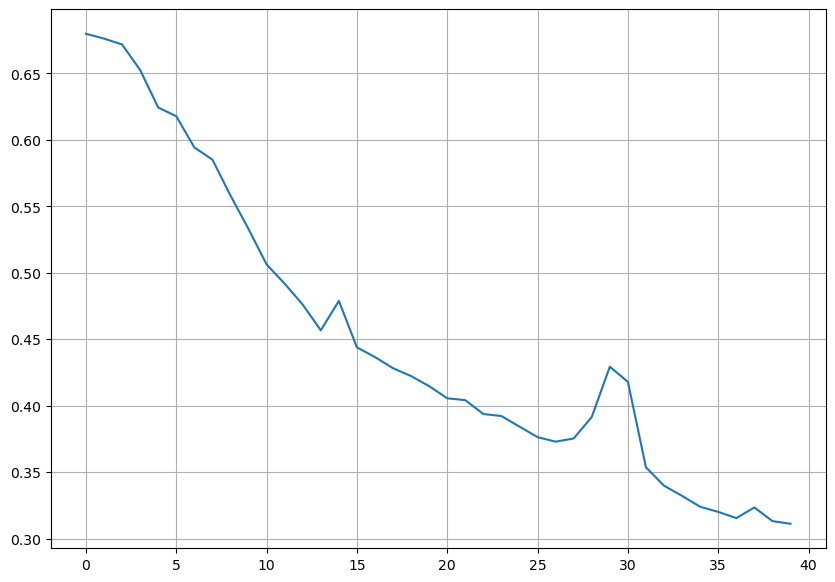

In [65]:
plt.figure(figsize=(10,7))
mvg_steps=question_sequence_len

#for i in range(len(loss_list)-mvg_steps):
#    loss_moving_avg.append(np.mean(loss_list[mvg_steps*i:(i+1)*mvg_steps]))
plt.grid()
#plt.plot(loss_list)
plt.plot(loss_moving_avg)


In [66]:
question_sequence_len=int(question_sequence.shape[1]*.8)
question_sequence_len

156

In [67]:
question_sequence.shape[1]

195

In [68]:
users_question_sequence[0][2].shape


(195,)

In [83]:
def test(model):
    with torch.no_grad():
        total_loss=0
        for user_count,question_sequence in enumerate(users_question_sequence):
                question_sequence_len=int(question_sequence.shape[1]*.8)
                total_loss=total_loss+loss.item()
                batch_accuracy=[]
                batch_target=[]
                batch_prob=[]

                for  batch_num in range(question_sequence_len,question_sequence.shape[1]):

                    model.eval()

                    answer=torch.tensor([question_sequence[2][batch_num]]).float()

                    out,node_embeddings=model(data.x_dict, data.edge_index_dict,batch_num,lookback,question_sequence,new_train_seq) 
                    loss=F.binary_cross_entropy(out,answer)
                    train_correct=out.round()==answer

                    train_acc=train_correct*1
                    accuracy=(train_correct*1).item()
                    epoch_accuracy.append(accuracy)
                    prob.append(out.item())
                    target.append(answer.item())
                    batch_target.append(answer.item())
                    batch_prob.append(out.item() )
                    batch_accuracy.append(accuracy)
                    total_loss=total_loss+loss.item()
                batch_performance = 'test_sequence_size : {} | accuracy {:.5f} | auc {:.5f} \n'.format(question_sequence.shape[1]-question_sequence_len,
                                                                                                       np.mean(batch_accuracy),
                                                                                                       roc_auc_score(np.array(batch_target), batch_prob))

                print(batch_performance)
                print('loss {}'.format(total_loss/(question_sequence.shape[1]-question_sequence_len)))
        #performance='accuracy {:.5f} | auc {:.5f} \n'.format(np.mean(epoch_accuracy),roc_auc_score(np.array(target),prob))



In [84]:
test(model)

UnboundLocalError: local variable 'loss' referenced before assignment

In [49]:
out.item()

0.6822903156280518

In [50]:
user_embedings[0][0].shape

torch.Size([203])

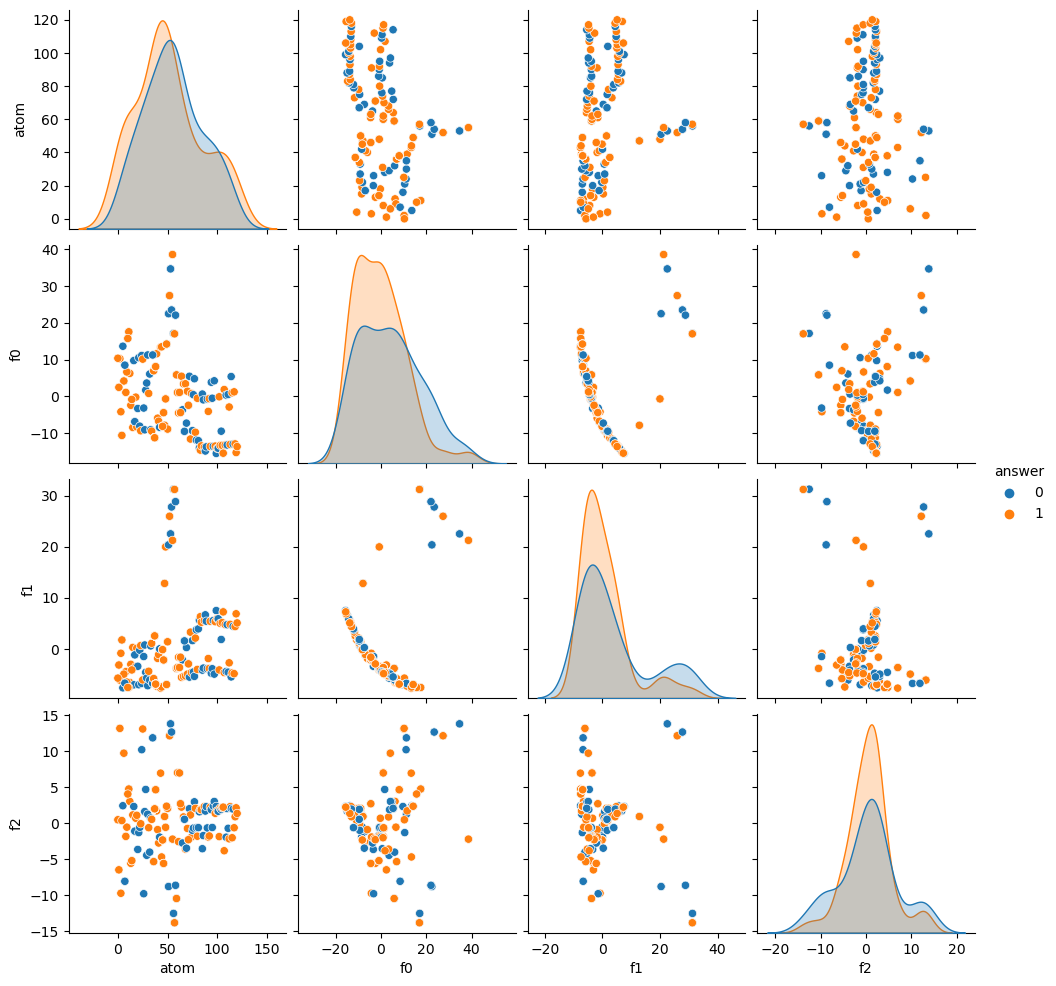

In [51]:
node_embeddings=[i[0] for i in user_embedings]

nodes=torch.stack(node_embeddings).detach().numpy()

nodesDf=pd.DataFrame(nodes[-question_sequence_len:])

pca = PCA(n_components=3)
components = pca.fit_transform(nodesDf)

#pcadf=pd.DataFrame({'f1':components[:,0],'f2':components[:,1]})
pcadf=pd.DataFrame({ 'f'+str(i):components[:,i]  for i in  range(components.shape[1]) })

answersdf=pd.DataFrame({'atom':question_sequence[1][lookback:],'answer':question_sequence[2][lookback:]})

pcadf=pcadf.reset_index().rename(columns={'index':'atom'})

answersdffea=answersdf.merge(pcadf,on='atom',how='left')

sns.pairplot(answersdffea,hue='answer')

In [205]:
hidden_channels=64
final_layer_dim=hidden_channels/4
class GNN_Lstm(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = SAGEConv((-1, -1), hidden_channels,requires_grad=True)
        self.actfn1=nn.ReLU()
        
        self.conv2 = SAGEConv((-1, -1),int( hidden_channels/2),requires_grad=True)
        self.actfn2=nn.ReLU()
        
        self.conv3 = SAGEConv((-1, -1),int( final_layer_dim),requires_grad=True)
        self.actfn3=nn.ReLU()
        
        self.conv4 = SAGEConv((-1, -1),int( hidden_channels/8),requires_grad=True)
        self.actfn4=nn.ReLU()
        
        
        self.sigmoid= nn.Sigmoid()

    def forward(self, x, edge_index):
        
        x = self.actfn1(self.conv1(x, edge_index))
        #x= F.dropout(x,p=.5,training=self.training)
        
        x = self.actfn2(self.conv2(x, edge_index))
        #x= F.dropout(x,p=.7,training=self.training)
        
        x = self.actfn3(self.conv3(x, edge_index))
        
        #out = self.actfn4(self.conv4(x, edge_index))
        
        #out= F.dropout(x,p=.7,training=self.training)
        #pool={key: gmp(out[key].x, out[key].batch) for key in out.node_types}
        #out=self.sigmoid( self.out(x))
        #ic(pool)
        
        #pool=gmp(out)
        return x

In [206]:
lookback=3
input_size=33
out_channels=1
num_layers=1
hidden_size=20
class Classifer_Lstm(nn.Module):
    
    def __init__(self ):
        super().__init__()
        self.num_layers = num_layers # number of recurrent layers in the lstm
        self.input_size = input_size # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        self.sigmoid=nn.Sigmoid()
        
        self.lstm = nn.LSTM(
            input_size=self.input_size ,
            hidden_size=self.hidden_size,
            num_layers=self.num_layers,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self,x):
        #print(x.shape)
        h0 = torch.zeros(self.num_layers, 1, self.hidden_size).requires_grad_()
        # Initialize long-term memory
        c0 = torch.zeros(self.num_layers, 1, self.hidden_size).requires_grad_()
        # Pass all inputs to lstm layer
        out, _ = self.lstm(x, (h0, c0))
        #print(out.shape)
        out = self.sigmoid(self.fc(out[:, -1, :]))
        
        return out

In [51]:
class GNN_LSTM_Classifier(nn.Module):
    def __init__(self):
        super(GNN_LSTM_Classifier, self).__init__()
        
        self.model_embedding=GNN_Lstm()
        self.model_embedding = to_hetero(self.model_embedding, data.metadata(),aggr='max')
        self.classifer = Classifer_Lstm()
        #lo,atom,prev_answer,prev_lo,prev_atom,prev_answer1,prev_lo1,prev_atom1
    def forward(self, x,edges,batch_num,lookback,question_sequence):
        node_embeddings = self.model_embedding(x,edges)
        rnn_input_list=[]
        #features_concat_list=[]
        
        for i in range(lookback+1):
            
            #print([i,batch_num-i])
            lo=question_sequence[0][batch_num-i]
            atom=question_sequence[1][batch_num-i]
            prev_answer=torch.tensor([question_sequence[2][batch_num-1-i]]).float()

            features_concat=torch.cat([node_embeddings['atom'][atom],node_embeddings['lo'][lo],prev_answer])
            rnn_input_list.append(features_concat)
        
                                         
            
        #user_embeddings=torch.cat([node_embeddings['atom'][atom] , node_embeddings['lo'][lo],prev_answer,node_embeddings['atom'][prev_atom] , node_embeddings['lo'][prev_lo],prev_answer1,node_embeddings['atom'][prev_atom1] , node_embeddings['lo'][prev_lo1]])  
       
        rnn_input_stacked=torch.stack(rnn_input_list).view(1,lookback+1,features_concat.shape[0])

        rnn_outputs = self.classifer(rnn_input_stacked)
    
        return rnn_outputs,node_embeddings

In [52]:
training_size=sum([users_question_sequence_train_lists[i].shape[1] for i in range(len(users_question_sequence_train_lists))])

model=GNN_LSTM_Classifier()
learning_rate=0.001
optimizer=torch.optim.Adam(model.parameters(),lr=learning_rate,weight_decay=5e-12)
criterion=torch.nn.BCELoss()
#criterion=F.binary_cross_entropy
train_acc_mean_list=[]
test_acc_mean_list=[]
loss_list=[]
accuracy_list=[]
best_score=0

torch.manual_seed(42)
loss_moving_avg=[]
user_embedings=[]
for epoch_num in range(100):
    epoch_accuracy=[]
    out_list=[]
    total_loss=0
    
    prob=[]
    target=[]
    for user_count,question_sequence in enumerate(users_question_sequence_train_lists):
        question_sequence_len=question_sequence.shape[1]
        batch_loss=0
        for  batch_num in range(lookback,question_sequence_len):

            model.train()

            optimizer.zero_grad()   
            #x_dict = {key: gmp(batch[key].x, batch[key].batch) for key in batch.node_types}


            answer=torch.tensor([question_sequence[2][batch_num]]).float()


            out,node_embeddings=model(data.x_dict, data.edge_index_dict,batch_num,lookback,question_sequence) 

            loss=F.binary_cross_entropy(out.view(1),answer)
            loss.backward()
            optimizer.step()

            loss_list.append(loss.item())
            total_loss=total_loss+loss.item()
            train_correct=out.round()==answer

            train_acc=train_correct*1
            accuracy=(train_correct*1).item()
            epoch_accuracy.append(accuracy)
            #accuracy_list.append(accuracy)
            prob.append(out.item())
            target.append(answer.item())
            batch_loss=batch_loss+loss.item()
        print('epoch {} | batch {} | batch loss {:.5f}'.format(epoch_num,user_count+1,batch_loss/question_sequence_len))
    
    performance='epoch {} | loss {:.5f} | accuracy {:.5f} | auc {:.5f} \n'.format(epoch_num,total_loss/(training_size),np.mean(epoch_accuracy),roc_auc_score(np.array(target),prob))
    print('-'*len(performance))
    print(performance)
    
    loss_moving_avg.append(total_loss/(batch_num+1))
        

epoch 0 | batch 1 | batch loss 0.67909
epoch 0 | batch 2 | batch loss 0.68748
epoch 0 | batch 3 | batch loss 0.66605
epoch 0 | batch 4 | batch loss 0.68876
epoch 0 | batch 5 | batch loss 0.67844
---------------------------------------------------------
epoch 0 | loss 0.68214 | accuracy 0.54627 | auc 0.49140 

epoch 1 | batch 1 | batch loss 0.68009
epoch 1 | batch 2 | batch loss 0.68610
epoch 1 | batch 3 | batch loss 0.66114
epoch 1 | batch 4 | batch loss 0.68771
epoch 1 | batch 5 | batch loss 0.67760
---------------------------------------------------------
epoch 1 | loss 0.68092 | accuracy 0.54717 | auc 0.48694 

epoch 2 | batch 1 | batch loss 0.68001
epoch 2 | batch 2 | batch loss 0.68513
epoch 2 | batch 3 | batch loss 0.65904
epoch 2 | batch 4 | batch loss 0.68768
epoch 2 | batch 5 | batch loss 0.67711
---------------------------------------------------------
epoch 2 | loss 0.68031 | accuracy 0.54537 | auc 0.50332 

epoch 3 | batch 1 | batch loss 0.67984
epoch 3 | batch 2 | batch lo

In [82]:

with torch.no_grad():
   
    for user_count,question_sequence in enumerate(users_question_sequence_test_lists):
            question_sequence_len=question_sequence.shape[1]
            batch_accuracy=[]
            batch_target=[]
            batch_prob=[]
            for  batch_num in range(lookback,question_sequence_len):

                model.eval()
                answer=torch.tensor([question_sequence[2][batch_num]]).float()

                out,node_embeddings=model(data.x_dict, data.edge_index_dict,batch_num,lookback,question_sequence) 

                train_correct=out.round()==answer

                train_acc=train_correct*1
                accuracy=(train_correct*1).item()
                epoch_accuracy.append(accuracy)
                prob.append(out.item())
                target.append(answer.item())
                batch_target.append(answer.item())
                batch_prob.append(out.item() )
                batch_accuracy.append(accuracy)
            batch_performance = 'test_sequence_size : {} | accuracy {:.5f} | auc {:.5f} \n'.format(question_sequence_len,np.mean(batch_accuracy),
                                                                             roc_auc_score(np.array(batch_target), batch_prob))
                
            print(batch_performance)
      
    performance='accuracy {:.5f} | auc {:.5f} \n'.format(np.mean(epoch_accuracy),roc_auc_score(np.array(target),prob))
    print('-'*len(performance))
    print(performance)


test_sequence_size : 42 | accuracy 0.48718 | auc 0.49198 

test_sequence_size : 77 | accuracy 0.51351 | auc 0.44689 

test_sequence_size : 34 | accuracy 0.61290 | auc 0.68571 

test_sequence_size : 75 | accuracy 0.58333 | auc 0.67857 

test_sequence_size : 71 | accuracy 0.58824 | auc 0.60434 

--------------------------------
accuracy 0.64999 | auc 0.70388 



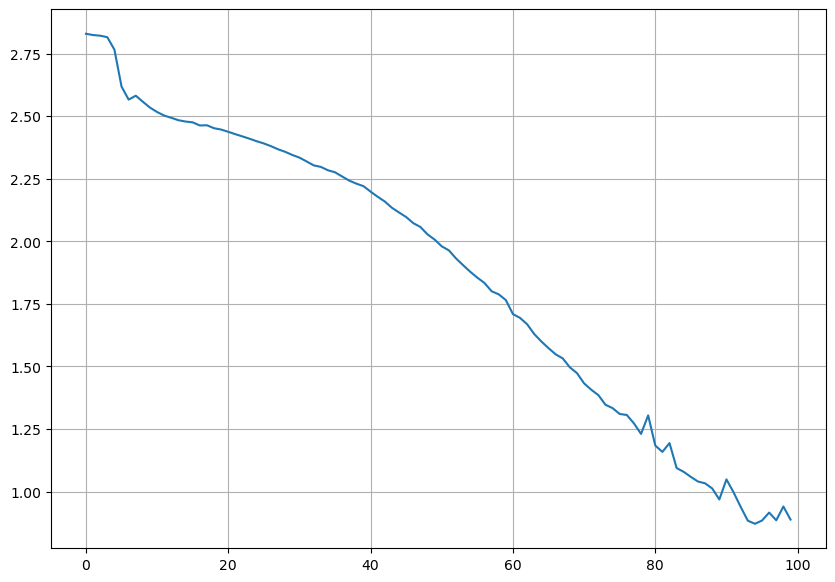

In [54]:
plt.figure(figsize=(10,7))
mvg_steps=question_sequence_len

#for i in range(len(loss_list)-mvg_steps):
#    loss_moving_avg.append(np.mean(loss_list[mvg_steps*i:(i+1)*mvg_steps]))
plt.grid()
#plt.plot(loss_list)
plt.plot(loss_moving_avg)


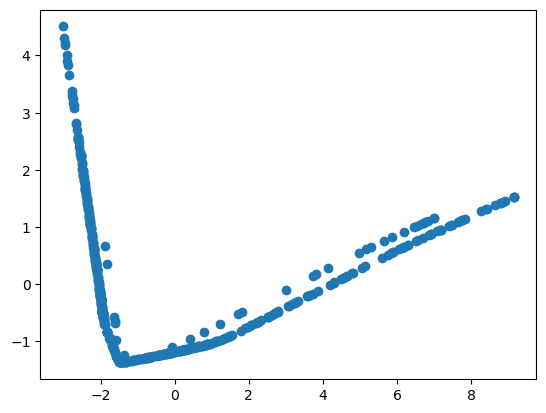

In [55]:
atoms=node_embeddings['atom'].detach().numpy()
pca = PCA(n_components=3)
components = pca.fit_transform(atoms)
plt.scatter(components[:,0],components[:,1])

In [56]:
los=node_embeddings['lo'].detach().numpy()
pca = PCA(n_components=3)
components1 = pca.fit_transform(los)


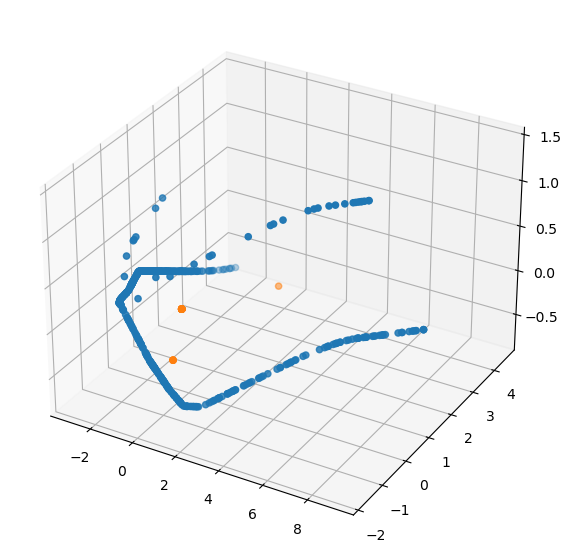

In [57]:
fig = plt.figure(figsize=(10,7))
ax = plt.axes(projection='3d')

ax.scatter(components[:,0], components[:,1], components[:,2]);
ax.scatter(components1[:,0], components1[:,1], components1[:,2] );

In [58]:
seq_features=[]
for i in range(3,question_sequence_len):
    seq_features.append(torch.cat([node_embeddings['atom'][question_sequence[1][i]].detach(),
                                   #node_embeddings['lo'][question_sequence[0][i]].detach(),
                                   #torch.tensor([question_sequence[-1][i-1]]),
                                   
                                    node_embeddings['atom'][question_sequence[1][i-1]].detach(),
                                   #node_embeddings['lo'][question_sequence[0][i-1]].detach(),
                                   #torch.tensor([question_sequence[-1][i-2]]),
                                   
                                    node_embeddings['atom'][question_sequence[1][i-2]].detach(),
                                   #node_embeddings['lo'][question_sequence[0][i-2]].detach(),
                                   #torch.tensor([question_sequence[-1][i-3]])
                                  
                                  
                                  ]).numpy())

In [59]:

#first_user_sq_length=dfg[dfg.user_id==dfg.user_id.unique()[0]].shape[0]
first_user_sq_length=0
second_user_sq_length=dfg[dfg.user_id==dfg.user_id.unique()[1]].shape[0]

In [60]:
np.stack(seq_features ).shape

(68, 48)

In [61]:
pca = PCA(n_components=3)
components2 = pca.fit_transform(np.stack(seq_features ) )
                            #[first_user_sq_length:first_user_sq_length+second_user_sq_length])


In [62]:
question_sequence[-1][3:first_user_sq_length+3].shape

(0,)

In [63]:
components2.shape

(68, 3)

In [64]:
pcadf=pd.DataFrame({ 'f'+str(i):components2[:,i]  for i in  range(components2.shape[1]) })


pcadf['answers']=question_sequence[-1][3:second_user_sq_length+3]



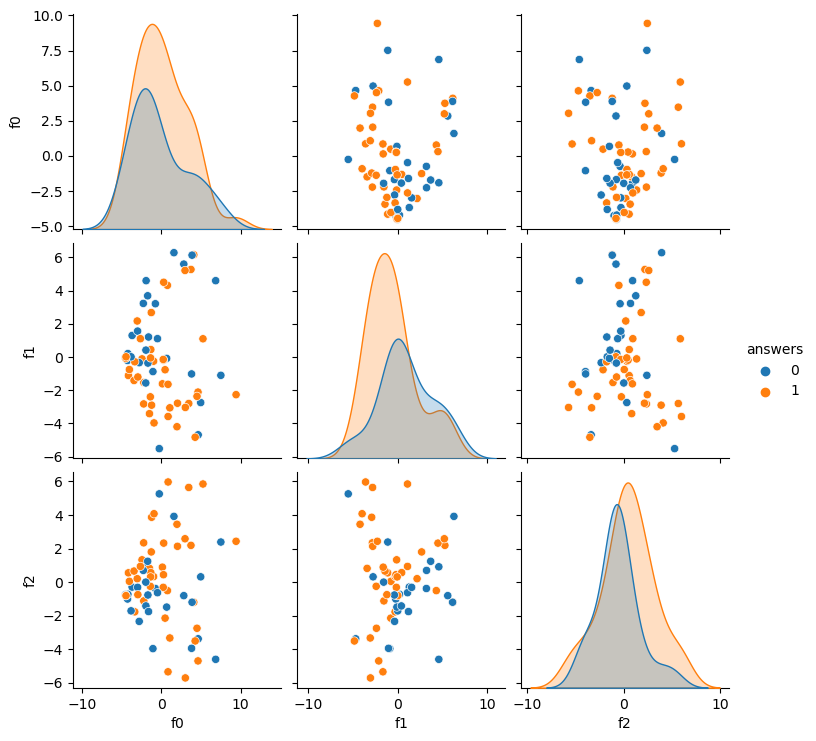

In [65]:
   
sns.pairplot(pcadf,hue='answers')
plt.show() 

In [66]:
from matplotlib.animation import FFMpegWriter, PillowWriter

In [67]:
metadata = dict( artist='codinglikemad')
# writer = PillowWriter(fps=15, metadata=metadata)
writer = FFMpegWriter(fps=10, metadata=metadata)

In [68]:
plt.rcParams['animation.ffmpeg_path'] = "C:\\research\\ffmpeg-4.4-full_build\\bin\\ffmpeg.exe"

In [69]:
fig = plt.figure(figsize=(100,100))
ax = plt.axes(projection='3d')
correct=pcadf[pcadf.answers==1]
falls=pcadf[pcadf.answers==0]
#ax.set_xlabel('f0')
#ax.set_ylabel('f1')
#ax.set_zlabel('f2')
#ax.scatter3D(correct.iloc[:,1], correct.iloc[:,2], correct.iloc[:,0],label='correct');
#ax.scatter3D(falls.iloc[:,1], falls.iloc[:,2], falls.iloc[:,0],label='wrong');
#plt.legend()
S=2500
angle1=30
with writer.saving(fig, "exp3d.gif", 10):
    for i in tqdm(range(0,720,2)):
        
        ax.set_xlabel('f0',fontsize=100)
        ax.set_ylabel('f1',fontsize=100)
        ax.set_zlabel('f2',fontsize=100)
        ax.scatter3D(correct.iloc[:,1], correct.iloc[:,2], correct.iloc[:,0],label='correct',s=S);
        ax.scatter3D(falls.iloc[:,1], falls.iloc[:,2], falls.iloc[:,0],label='wrong',s=S);
        plt.legend(markerscale=2,fontsize=100)
        
        ax.view_init(45, i);

        writer.grab_frame()
        plt.cla()

100%|████████████████████████████████████████████████████████████████████████████████| 360/360 [01:38<00:00,  3.66it/s]


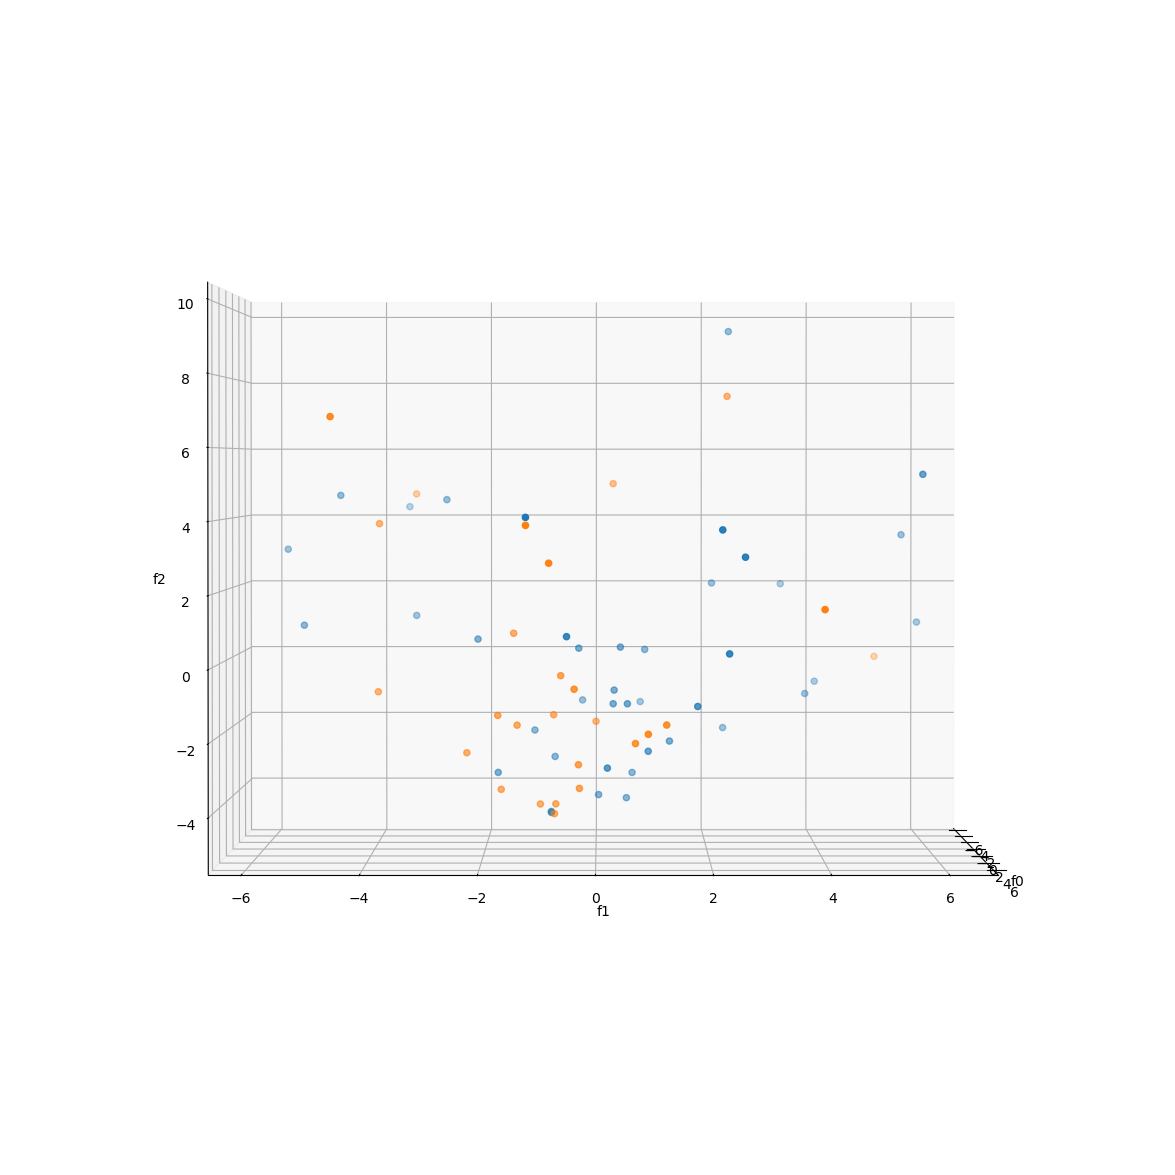

In [70]:

#fig = plt.figure()

def animate(angle):
    ax.view_init(30, angle)
#animate(10)
fig = plt.figure(figsize=(15,15))
ax = plt.axes(projection='3d')
correct=pcadf[pcadf.answers==1]
falls=pcadf[pcadf.answers==0]
   
for i in range(1,360,72):
    ax.set_xlabel('f0')
    ax.set_ylabel('f1')
    ax.set_zlabel('f2') 
    ax.scatter3D(correct.iloc[:,1], correct.iloc[:,2], correct.iloc[:,0],label='correct');
    ax.scatter3D(falls.iloc[:,1], falls.iloc[:,2], falls.iloc[:,0],label='wrong');
    #plt.legend()
    ax.view_init(i, 0);
    #ax.draw();
    plt.pause(.001);
    ax.cla()
#ani = FuncAnimation(fig, animate, frames=range(360))
   
  
    

In [71]:
animate(20)

In [72]:
falls.mean()

f0        -0.188708
f1         0.912921
f2        -0.620055
answers    0.000000
dtype: float64